# Recursive Bayesian Estimation

### Background Info
- https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation
- https://en.wikipedia.org/wiki/Kalman_filter
- https://en.wikipedia.org/wiki/Particle_filter
- Original Kalman filter paper. https://www.cs.unc.edu/~welch/kalman/kalmanPaper.html
- Good step-by-step breakdown of Bayes Filter math. https://johnwlambert.github.io/bayes-filter/
- Alpha-Beta filter. https://medium.com/@mathiasmantelli/kalman-filter-series-introduction-6d2e2b28d4cf
- Bayes filter. https://medium.com/@mathiasmantelli/kalman-filter-part-2-bayes-filter-f2fa9c0b5c95
- Kalman filter. https://medium.com/@mathiasmantelli/kalman-filter-part-3-a-formal-discussion-e1a61b359fef
- Particle filter 1. https://medium.com/@mathiasmantelli/particle-filter-part-1-introduction-fb6954bc12ec
- Particle filter 2. https://medium.com/@mathiasmantelli/particle-filter-part-2-intuitive-example-and-equations-0716223b862b
- Particle filter 3. https://medium.com/@mathiasmantelli/particle-filter-part-3-motion-and-measurement-models-be79857a5490
- Particle filter 4. https://medium.com/@mathiasmantelli/particle-filter-part-4-pseudocode-and-python-code-052a74236ba4

### Questions
- How does the entropy of model beliefs change depending on the entropy of the observations?
- How does the computational demand of a filter scale with dimensions of the state space?
- How to get around having to explicitly define state parameters from observations? Variational autoencoders?

### Table of Contents
1. Setup
2. Kalman Filter
3. Particle Filter

### 1. Setup 

Install and import the following required libraries.

In [19]:
# ! conda install numpy scipy matplotlib

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm, multivariate_normal
from IPython.display import clear_output
import time

### 2. Kalman Filter

Basic Kalman filter. Two assumptions:
1. All errors are Gaussian in distribution.
2. Model dynamics are linear.


In [21]:
class KalmanFilter():
    def __init__(self, initial_state_estimate, initial_error_covariance, process_covariance, measurement_covariance,
                 state_transition_matrix, control_input_matrix, measurement_matrix):
        self.n = len(initial_state_estimate)  # Dimension of state vector.
        self.x_hat_k_minus_1 = initial_state_estimate
        self.P_k_minus_1 = initial_error_covariance

        self.F = state_transition_matrix
        self.B = control_input_matrix
        self.Q = process_covariance  # Process noise covariance matrix.
        self.H = measurement_matrix
        self.R = measurement_covariance  # Measurement noise covariance matrix.
        
        # These variables will be updated by the predict and update functions.
        self.x_hat_k_prior = None  # Predicted mean prior to measurement at time k.
        self.P_k_prior = None # Predicted error covariance at time k.
        self.K_k = None  # Kalman gain at time k.
        self.x_hat_k = None  # Mean after measurement at time k. 
        self.P_k = None  # Error covariance after measurement at time k.

    def predict(self, u_k):
        self.x_hat_k_prior = self.F * self.x_hat_k_minus_1 + self.B * u_k  # Predict state.
        self.P_k_prior = self.F * self.P_k_minus_1 * self.F.T + self.Q  # Predict error covariance.

    def update(self, z_k):
        # Calculate Kalman gain.
        self.K_k = self.P_k_prior * self.H.T * np.linalg.inv(self.H * self.P_k_prior * self.H.T + self.R)

        self.x_hat_k = self.x_hat_k_prior + self.K_k * (z_k - self.H * self.x_hat_k_prior)  # Update state estimate.
        self.P_k = (np.identity(self.n) - self.K_k * self.H) * self.P_k_prior  # Update error covariance.

        # Recurse.
        self.x_hat_k_minus_1 = self.x_hat_k
        self.P_k_minus_1 = self.P_k

Initialize a Kalman filter for a two-dimensional system. (One space dimension and another its derivative, velocity.) All control inputs are 0. Process and measurement convariances are both identity matrices.

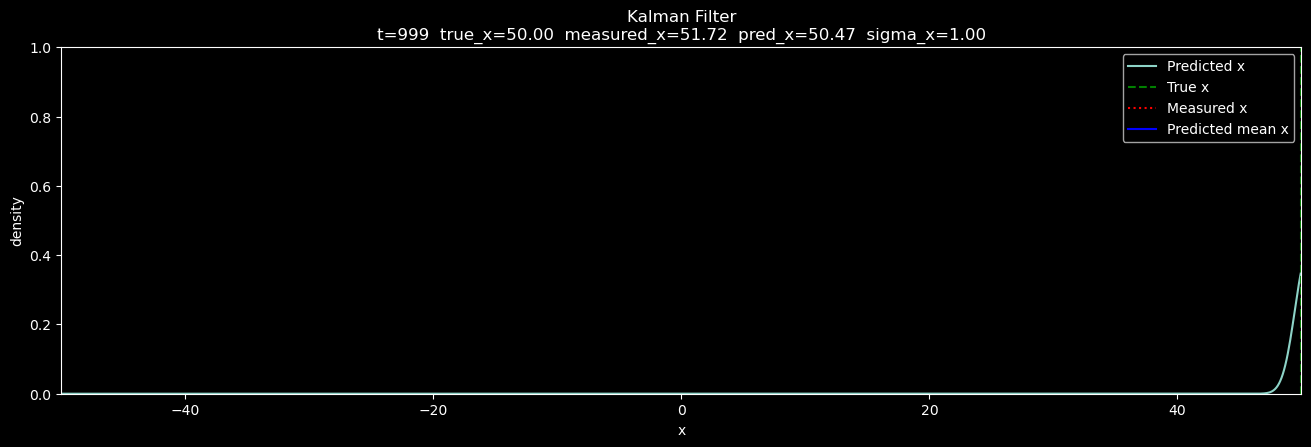

In [22]:
# Two-dimensional system (position x and velocity v). Measurement is position x only.
initial_state_estimate = np.array([0, 0])  # x = 0, v = 0
initial_error_covariance = np.identity(2) * 10000  # Large initial covariance.
process_covariance = np.identity(2)
measurement_covariance = np.identity(1) * 1000
state_transition_matrix = np.array([[1, 1],  # x = v * dt
                                    [0, 1]])
control_input_matrix = np.array([[0, 0],
                                 [0, 1]])  # Control input only affects velocity.
measurement_matrix = np.identity(1)

kf = KalmanFilter(initial_state_estimate, initial_error_covariance, process_covariance, measurement_covariance,
                  state_transition_matrix, control_input_matrix, measurement_matrix)

true_x = -50
for t in range(1000):
    true_x += 0.1 
    u_k = 0  # No control input.
    z_k = true_x + np.random.normal(loc=0, scale=1)

    kf.predict(u_k)
    kf.update(z_k)

    # Extract predicted position and velocity.
    pred_x = kf.x_hat_k[0][0]
    # Standard deviation of x (position).
    sigma_x = np.sqrt(kf.P_k[0][0])

    clear_output(wait=True)
    plt.figure(figsize=(16,4.5))
    # Plot normal distribution for predicted position.
    x_vals = np.linspace(-50, 50, 1000)
    plt.plot(x_vals, norm.pdf(x_vals, pred_x, sigma_x), label='Predicted x')
    # Plot true position, measured position, predicted position.
    plt.axvline(true_x, color='green', linestyle='--', label='True x')
    plt.axvline(z_k, color='red', linestyle=':', label='Measured x')
    plt.axvline(pred_x, color='blue', linestyle='-', label='Predicted mean x')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('density')
    plt.title(f'Kalman Filter\nt={t}  true_x={true_x:.2f}  measured_x={z_k:.2f}  pred_x={pred_x:.2f}  sigma_x={sigma_x:.2f}')
    plt.xlim(-50, 50)
    plt.ylim(0, 1)
    plt.show()
    #time.sleep(1)

### 3. Particle Filter

Basic particle filter, i.e. Sequential Monte Carlo / Monte Carlo Localization. No assumption of Gaussian errors and no assumption of linear transition and observation relationships.

- How should the number of particles scale with the number of dimensions in the problem?
- How should the number of particles scale with the uncertainty of observations?


In [25]:
class ParticleFilter():
    def __init__(self, N, dims, transition_model, measurement_model):
        self.N = N  # Number of particles.
        self.particles_k_minus_1 = np.zeros((dims, self.N))  # (dims, N). All particles start at x = 0, v = 0.
        self.particles_weight = np.ones(self.N) * 1/self.N  # (N). All weights start as 1/N
        self.transition_model = transition_model
        self.measurement_model = measurement_model

        self.particles_k_prior = None
        self.particles_k = None

    def predict(self, u_k):
        self.particles_k_prior = self.transition_model(self.particles_k_minus_1, u_k)
    
    def update(self, z_k):
        # Set weight of each particle as likelihood given z_k.
        self.particles_weight = self.measurement_model(self.particles_k_prior, z_k)

        # Normalize weights so they sum to 1.
        self.particles_weight /= np.sum(self.particles_weight)

        # Systematic resampling
        N = self.N
        positions = (np.arange(N) + np.random.uniform()) / N
        cumulative_sum = np.cumsum(self.particles_weight)
        indexes = np.zeros(N, dtype=int)
        i, j = 0, 0
        while i < N and j < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        # Resample particles
        self.particles_k = self.particles_k_prior[:, indexes]
        # Reset weights to uniform
        self.particles_weight = np.ones(N) * 1.0 / N
        # Prepare for next step
        self.particles_k_minus_1 = self.particles_k


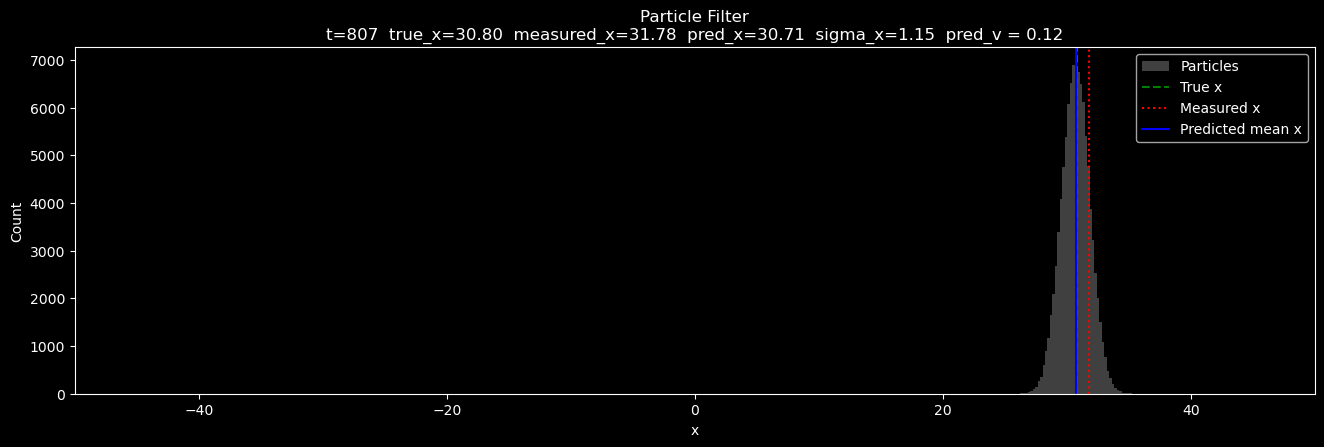

In [ ]:
def transition_model(particles_k_minus_1, u_k):  # Still a linear transition model, but can change. 
    process_covariance = np.identity(particles_k_minus_1.shape[0]) * 0.001 # Process noise variance.
    transition_matrix = np.array([[1, 1],
                                  [0, 1]])
    particles_k_prior = np.matmul(transition_matrix, particles_k_minus_1) + np.random.multivariate_normal(mean=[0,0], cov=process_covariance, size=particles_k_minus_1.shape[1]).T
    return particles_k_prior

def measurement_model(particles_k_prior, z_k):  # Still a linear measurement model with Gaussian measurment noise.
    measurement_covariance = np.identity(particles_k_prior.shape[0]) * 10  # Measurement noise variance.
    particles_k_prior = particles_k_prior[0].T  # Use only position dimension for measurement
    particles_weight = norm.pdf(z_k, loc=particles_k_prior, scale=np.sqrt(measurement_covariance[0,0]))
    return particles_weight

pf = ParticleFilter(100000, 2, transition_model, measurement_model)

true_x = -50
for t in range(1000):
    true_x += 0.1 
    u_k = 0  # No control input.
    z_k = true_x + np.random.normal(loc=0, scale=1)

    pf.predict(u_k)
    pf.update(z_k)

    # Weighted mean and std of position (first dimension)
    pred_x = np.sum(pf.particles_k[0] * pf.particles_weight)
    sigma_x = np.sqrt(np.sum(pf.particles_weight * (pf.particles_k[0] - pred_x)**2))
    pred_v = np.sum(pf.particles_k[1] * pf.particles_weight)

    clear_output(wait=True)
    plt.figure(figsize=(16,4.5))
    # Plot histogram of all particles (positions)
    plt.hist(pf.particles_k[0], bins=50, color='gray', alpha=0.5, label='Particles')
    # Plot true position, measured position, predicted position.
    plt.axvline(true_x, color='green', linestyle='--', label='True x')
    plt.axvline(z_k, color='red', linestyle=':', label='Measured x')
    plt.axvline(pred_x, color='blue', linestyle='-', label='Predicted mean x')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Count')
    plt.title(f'Particle Filter\nt={t}  true_x={true_x:.2f}  measured_x={z_k:.2f}  pred_x={pred_x:.2f}  sigma_x={sigma_x:.2f}  pred_v = {pred_v:.2f}')
    plt.xlim(-50, 50)
    plt.show()
    #time.sleep(1)
